In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
from hardware.timetagger_counter import HWRecorderMode

[2.85978e+09 2.86578e+09]


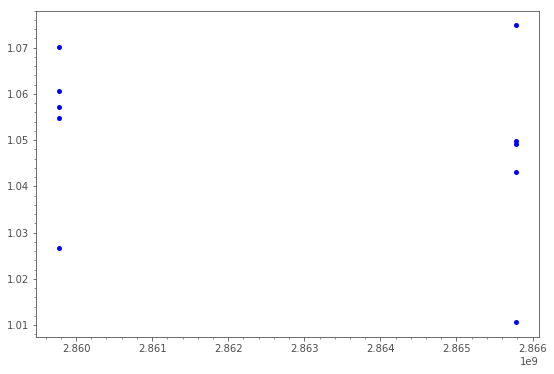

In [23]:
self = afm_scanner_logic
res_freq = 2.86278e9
delta_0 = 3e6
num_runs = 60000
pi_half_duration = 250e-9
mw_power = -3

freq_points = 2
var_start = round(res_freq - delta_0,0)
var_stop = round(res_freq + delta_0,0)
var_incr = round((var_stop-var_start)/freq_points,0)

alternating = False
laser_pulses = freq_points # is normally not used for mw_list_mode or mw_tracking_mode
bin_width_s = self._podmr.bin_width_s
record_length_s = self._podmr.record_length_s
analysis_settings = self._podmr.pulsed_analysis_settings
var_list = np.linspace(var_start, var_stop, freq_points, endpoint=True)
print(var_list)
    
ret_val = self._counter.configure_recorder(
                        mode=11,
                        params={'laser_pulses': freq_points,
                                'bin_width_s': bin_width_s,
                                'record_length_s': record_length_s,
                                'max_counts': int(num_runs-1)} )

self._pulser.prepare_SPM_ensemble()
# upload the IQ signal for + and - delta frequencies. Should be triggerable. Only the CW MW will change during scan
self._pulsed_master_AWG.toggle_pulse_generator(False)
# self._AWG.instance.init_all_channels()
self.load_AWG_sine_for_IQ(delta_0, pi_half_duration)            
self._AWG.load_triggered_multi_replay(['SinSPM0', 'SinSPM1']) # refer to load_AWG_sine_for_IQ for names

self._pulsed_master_AWG.pulsedmeasurementlogic().pulsegenerator().pulser_on(trigger=True)

#everything else can remain the same
self._pulser.load_swabian_sequence(self._make_pulse_sequence(mode = 'PODMR_AWG', pi_half_pulse = pi_half_duration))
self._podmr_seq = self._pulser._seq
self._pulser.load_swabian_sequence(self._make_pulse_sequence('NextTrigger'))
self._next_trigger_seq = self._pulser._seq

self._mw.set_cw_2(res_freq, mw_power)

num_runs *= freq_points # necessary for the two frequencies in mode to have enough reps

for i in range(5):
    
    self._counter.start_recorder(arm=True)
    # start actual scan
    if self._counter.recorder.getHistogramIndex()==-1:
        self._pulser._seq = self._next_trigger_seq
        self._pulser.pulser_on(n=1)
        while True:
            if self._pulser.pulse_streamer.hasFinished():
                break

    self._pulser._seq = self._podmr_seq
    self._mw.set_cw_3(res_freq, mw_power) # minimal cw set function _3 is used which does not repeat setting of power
    self._mw.cw_on_3()

    self._pulser.pulser_on(trigger=False, n=num_runs, final=None)

    # obtain pulsed measurement
    pulsed_meas = self._counter.get_measurements()[0]
    pulsed_ret0, pulsed_ret1 = self.analyse_pulsed_meas(analysis_settings, pulsed_meas, alternating, False, True)
    self._debug = pulsed_ret0

    plt.plot(var_list,pulsed_ret0,'bo')
plt.show()

0

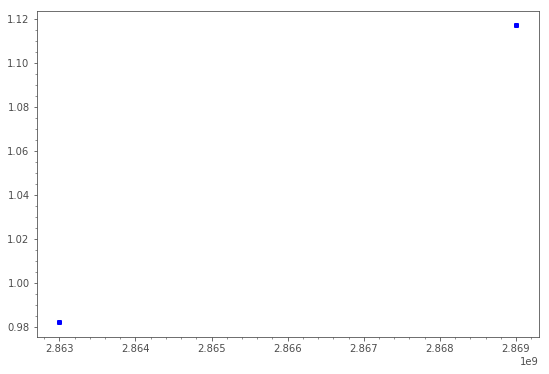

In [14]:

self._mw.off()
self._counter.stop_measurement()
self._pulser.pulser_off()

In [3]:
import pickle

In [8]:
f = "G:\\Data\\Qudi_Data\\2024\\06\\20240621\\AttoDRY2200_Pi3_SPM\\"
filehandler = open(f+"qafm_array","wb")
pickle.dump(afm_scanner_logic._qafm_scan_array, filehandler)
filehandler.close()